In [ ]:
# default_exp fft

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
#export
from rtma.imports import *
from rtma.signal import *

# FFT

## Generate Inputs

### Signal

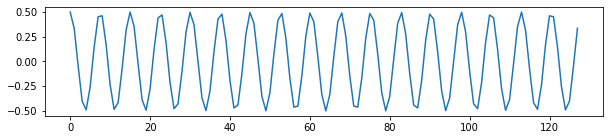

In [5]:
sr = 100
amp = 0.5
n_fft = 128
freq = sr / n_fft * 17

x = gen_sinusoid(amp, freq=freq, sample_rate=sr, num_samples=n_fft)
plot(x)

### Window

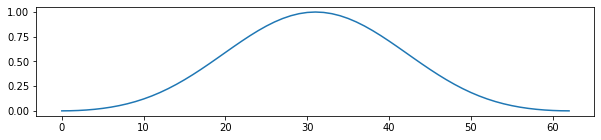

In [18]:
m = 63
w = get_window('blackman', m, False)
plot(w)

### Windowed Signal

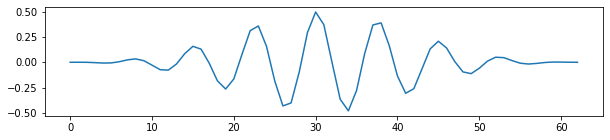

In [19]:
wx = x[:w.size] * w
plot(wx)

### Zero-phase FFT Bufferr

In [20]:
m1 = m//2
m2 = (m+1)//2
m, m1, m2

(63, 31, 32)

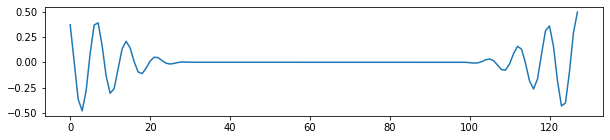

In [21]:
fft_buffer = np.zeros(n_fft)
fft_buffer[:m2] = wx[m1:]
fft_buffer[-m1:] = wx[:m1]
plot(fft_buffer)

### Generate Frequency Spectrum

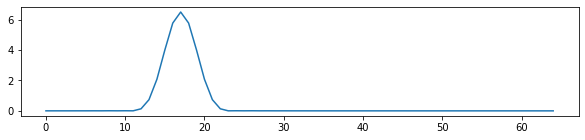

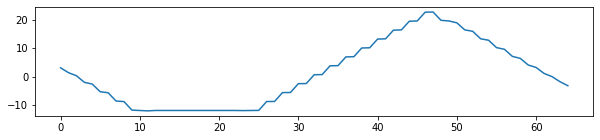

In [22]:
X = np.fft.rfft(fft_buffer, n=n_fft)
mx = abs(X)
px = np.unwrap(np.angle(X))

plot(mx)
plot(px)

In [24]:
mx[16:19]

array([5.78152986, 6.50998171, 5.78152641])

In [25]:
z = px[16:19]
z.min(), z.max()

(-11.8300615757085, -11.83003130904425)

## Analysis/Synthesis Functions

In [13]:
# export
def is_power_of_two(n: int) -> bool:
    return n > 1 and (n & (n-1)) == 0

In [ ]:
assert [n for n in np.arange(1000) if is_power_of_two(n)] == [2, 4, 8, 16, 32, 64, 128, 256, 512]

In [ ]:
#export
def zero_phase_buffer(x_or_buffer: np.ndarray,
                      n_fft: Optional[int] = None,
                      n_window: Optional[int] = None,
                      reverse: bool = False):
    x_or_buffer = np.array(x_or_buffer) # signal to be a list
    n_samples = x_or_buffer.shape[0]

    if reverse:
        buffer = x_or_buffer

        if n_window is None:
            n_window = n_samples

        center_i = n_window // 2
        x_left  = buffer[-center_i:]          # from the right side of buffer
        x_right = buffer[:n_window-center_i]  # from the left side of buffer

        x = np.concatenate([x_left, x_right])
        assert x.shape[0] == n_window
        return x

    else:
        x = x_or_buffer

        if n_fft:
            assert n_fft >= n_samples, 'n_fft must be >= the number of samples'
            assert is_power_of_two(n_fft), 'n_fft must be a power of two'
            buffer = np.zeros(n_fft, dtype=x.dtype)
        else:
            buffer = np.zeros_like(x, dtype=x.dtype)

        center_i = n_samples // 2
        x_left  = x[:center_i]  # always even length, does not include center sample
        x_right = x[center_i:] # odd if signal length is odd, otherwise even

        buffer[:x_right.size] = x_right  # placed on the left
        buffer[-x_left.size:] = x_left   # placed on the right, at the end
        return buffer

In [ ]:
x = np.arange(7)
buffer = zero_phase_buffer(x)
xh = zero_phase_buffer(buffer, reverse=True)
assert buffer.tolist() == [3,4,5,6,0,1,2]
assert np.array_equal(x, xh)

x = np.arange(7)
buffer = zero_phase_buffer(x, n_fft=16)
xh = zero_phase_buffer(buffer, n_window=7, reverse=True)
assert buffer.tolist() == [3,4,5,6,0,0,0,0,0,0,0,0,0,0,1,2]
assert np.array_equal(x, xh)

In [ ]:
# export
def fft_analysis(x, n_fft, thresh = 1e-14):
    assert x.size <= n_fft
    assert is_power_of_two(n_fft)

    pos_n_fft = (n_fft // 2) + 1

    fft_buffer = zero_phase_buffer(x, n_fft=n_fft)
    X = np.fft.rfft(fft_buffer)[:pos_n_fft]

    m_x = abs(X)

    X.real[abs(X.real) < thresh] = 0.0
    X.imag[abs(X.imag) < thresh] = 0.0
    p_x = np.unwrap(np.angle(X))

    return m_x, p_x

In [ ]:
x = gen_sinusoid(amp, freq=freq, sample_rate=sr, num_samples=n_fft)
xm = x[:m]

m_x, p_x = fft_analysis(xm, n_fft)
plot(x)
plot(m_x)
plot(p_x)

In [ ]:
# export
def fft_synthesis(m_x, p_x, m):
    assert m_x.shape == p_x.shape

    pos_n_fft = m_x.size
    n_fft = (pos_n_fft - 1) * 2
    assert is_power_of_two(n_fft)

    Y = m_x * np.exp(1j * p_x)
    fft_buffer = np.fft.irfft(Y)
    y = zero_phase_buffer(fft_buffer, n_window=m, reverse=True)

    return y

In [ ]:
y = fft_synthesis(m_x, p_x, m)
plot(y)

In [ ]:
assert np.isclose(xm, y).all()

TODO: decibel conversions

In [ ]:
mx_db = 20.0 *np.log10(m_x)
plot(mx_db)